In [116]:
import pandas as pd
import numpy as np
from statistics import mean 
import itertools
import pprint
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict 
import math
import random
from sklearn import preprocessing 

sns.set(rc={'figure.figsize':(12,8)})

In [123]:
df = pd.read_csv(r"H:\My Documents\Food.csv")

In [124]:
df

,Item,Calories,Sodium,Cluster
0,Hotdog,386,495,Cluster 1
1,Pizza,481,477,Cluster 1
2,Broccoli,76,45,Cluster 2
3,Spinach,49,22,Cluster 2
4,Ribs,584,482,Cluster 1
5,Cola,290,87,Cluster 3
6,Smoothie,258,50,Cluster 3
7,Hamburger,339,322,Cluster 1
8,Beer,299,42,Cluster 3
9,Fruit Juice,248,75,Cluster 3


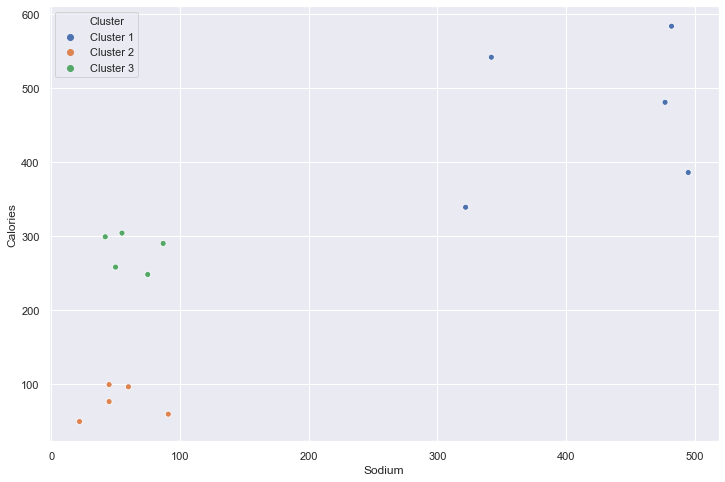

In [125]:
ax = sns.scatterplot(x="Sodium", y="Calories", data=df, hue = "Cluster")

In [89]:
def getMedian(alist):
    """get median of list"""
    tmp = list(alist)
    tmp.sort()
    alen = len(tmp)
    if (alen % 2) == 1:
        return tmp[alen // 2]
    else:
        return (tmp[alen // 2] + tmp[(alen // 2) - 1]) / 2
    

def normalizeColumn(column):
    """normalize the values of a column using Modified Standard Score
    that is (each value - median) / (absolute standard deviation)"""
    median = getMedian(column)
    asd = sum([abs(x - median) for x in column]) / len(column)
    result = [(x - median) / asd for x in column]
    return result

In [137]:
class kClustererpp:
    """ Implementation of kMeans Clustering
    This clusterer assumes that the first column of the data is a label
    not used in the clustering. The other columns contain numeric data
    """
    
    def __init__(self, filename, k):
        """ k is the number of clusters to make
        This init method:
           1. reads the data from the file named filename
           2. stores that data by column in self.data
           3. normalizes the data using Modified Standard Score
           4. randomly selects the initial centroids
           5. assigns points to clusters associated with those centroids
        """
        file = open(filename)
        self.data = {}
        self.k = k
        self.counter = 0
        self.iterationNumber = 0
        # used to keep track of % of points that change cluster membership
        # in an iteration
        self.pointsChanged = 0
        # Sum of Squared Error
        self.sse = 0
        #
        # read data from file
        #
        lines = file.readlines()
        file.close()
        header = lines[0].split(',')
        self.cols = len(header)
        self.data = [[] for i in range(len(header))]
        # we are storing the data by column.
        # For example, self.data[0] is the data from column 0.
        # self.data[0][10] is the column 0 value of item 10.
        for line in lines[1:]:
            cells = line.split(',')
            toggle = 0
            for cell in range(self.cols):
                if toggle == 0:
                   self.data[cell].append(cells[cell])
                   toggle = 1
                else:
                    self.data[cell].append(float(cells[cell]))
                    
        self.datasize = len(self.data[1])
        self.memberOf = [-1 for x in range(len(self.data[1]))]
        #
        # now normalize number columns
        #
        for i in range(1, self.cols):
                self.data[i] = normalizeColumn(self.data[i])

        # select random centroids from existing points
        random.seed()
        self.selectInitialCentroids()
        self.assignPointsToCluster()


    def showData(self):
        for i in range(len(self.data[0])):
            print("%20s   %8.4f  %8.4f" %
                (self.data[0][i], self.data[1][i], self.data[2][i]))

    def distanceToClosestCentroid(self, point, centroidList):
        result = self.eDistance(point, centroidList[0])
        for centroid in centroidList[1:]:
            distance = self.eDistance(point, centroid)
            if distance < result:
                result = distance
        return result


    def selectInitialCentroids(self):
        """implement the k-means++ method of selecting
        the set of initial centroids"""
        centroids = []
        total = 0
        # first step is to select a random first centroid
        current = random.choice(range(len(self.data[0])))
        centroids.append(current)
        # loop to select the rest of the centroids, one at a time
        for i in range(0, self.k - 1):
            # for every point in the data find its distance to
            # the closest centroid
            weights = [self.distanceToClosestCentroid(x, centroids) 
                       for x in range(len(self.data[0]))]
            total = sum(weights)
            # instead of raw distances, convert so sum of weight = 1
            weights = [x / total for x in weights]
            #
            # now roll virtual die
            num = random.random()
            total = 0
            x = -1
            # the roulette wheel simulation
            while total < num:
                x += 1
                total += weights[x]
            centroids.append(x)
        self.centroids = [[self.data[i][r]  for i in range(1, len(self.data))]
                            for r in centroids]
                
            
    
 
    def updateCentroids(self):
        """Using the points in the clusters, determine the centroid
        (mean point) of each cluster"""
        members = [self.memberOf.count(i) for i in range(len(self.centroids))]
        
        self.centroids = [[sum([self.data[k][i]
                            for i in range(len(self.data[0]))
                            if self.memberOf[i] == centroid])/members[centroid]
                           for k in range(1, len(self.data))]
                          for centroid in range(len(self.centroids))] 
            
        
    
    def assignPointToCluster(self, i):
        """ assign point to cluster based on distance from centroids"""
        min = 999999
        clusterNum = -1
        for centroid in range(self.k):
            dist = self.euclideanDistance(i, centroid)
            if dist < min:
                min = dist
                clusterNum = centroid
        # here is where I will keep track of changing points
        if clusterNum != self.memberOf[i]:
            self.pointsChanged += 1
        # add square of distance to running sum of squared error
        self.sse += min**2
        return clusterNum

    def assignPointsToCluster(self):
        """ assign each data point to a cluster"""
        self.pointsChanged = 0
        self.sse = 0
        self.memberOf = [self.assignPointToCluster(i)
                         for i in range(len(self.data[1]))]
        

    def eDistance(self, i, j):
        """ compute distance of point i from centroid j"""
        sumSquares = 0
        for k in range(1, self.cols):
            sumSquares += (self.data[k][i] - self.data[k][j])**2
        return math.sqrt(sumSquares)
      
    def euclideanDistance(self, i, j):
        """ compute distance of point i from centroid j"""
        sumSquares = 0
        for k in range(1, self.cols):
            sumSquares += (self.data[k][i] - self.centroids[j][k-1])**2
        return math.sqrt(sumSquares)

    def kCluster(self):
        """the method that actually performs the clustering
        As you can see this method repeatedly
            updates the centroids by computing the mean point of each cluster
            re-assign the points to clusters based on these new centroids
        until the number of points that change cluster membership is less than 1%.
        """
        done = False
 
        while not done:
            self.iterationNumber += 1
            self.updateCentroids()
            self.assignPointsToCluster()
            #
            # we are done if fewer than 1% of the points change clusters
            #
            if float(self.pointsChanged) / len(self.memberOf) <  0.01:
                done = True
        print("Final SSE: %f" % self.sse)
        print("K means++ Clustering")
    def showMembers(self):
        """Display the results"""
        for centroid in range(len(self.centroids)):
            print ("\n\nClass %i\n========" % centroid)
            for name in [self.data[0][i]  for i in range(len(self.data[0]))
                if self.memberOf[i] == centroid]:
                    print (name)
##
## RUN THE K-MEANS CLUSTERER ON THE DOG DATA USING K = 3
###
km = kClustererpp(r"H:\My Documents\FoodData.csv", 3)
km.kCluster()
km.showMembers()

Final SSE: 6.740945
K means++ Clustering


Class 0
"Cola
"Smoothie
"Fruit Juice
"Bloody Mary


Class 1
"Hotdog
"Pizza
"Ribs
"Hamburger
"Fries
"Chicken
"Wings


Class 2
"Broccoli
"Spinach
"Bok Choi
"Celery


In [138]:
class kClusterer:
    """ Implementation of kMeans Clustering
    This clusterer assumes that the first column of the data is a label
    not used in the clustering. The other columns contain numeric data
    """
    
    def __init__(self, filename, k):
        """ k is the number of clusters to make
        This init method:
           1. reads the data from the file named filename
           2. stores that data by column in self.data
           3. normalizes the data using Modified Standard Score
           4. randomly selects the initial centroids
           5. assigns points to clusters associated with those centroids
        """
        file = open(filename)
        self.data = {}
        self.k = k
        self.counter = 0
        self.iterationNumber = 0
        # used to keep track of % of points that change cluster membership
        # in an iteration
        self.pointsChanged = 0
        # Sum of Squared Error
        self.sse = 0
        #
        # read data from file
        #
        lines = file.readlines()
        file.close()
        header = lines[0].split(',')
        self.cols = len(header)
        self.data = [[] for i in range(len(header))]
        # we are storing the data by column.
        # For example, self.data[0] is the data from column 0.
        # self.data[0][10] is the column 0 value of item 10.
        for line in lines[1:]:
            cells = line.split(',')
            toggle = 0
            for cell in range(self.cols):
                if toggle == 0:
                   self.data[cell].append(cells[cell])
                   toggle = 1
                else:
                    self.data[cell].append(float(cells[cell]))
                    
        self.datasize = len(self.data[1])
        self.memberOf = [-1 for x in range(len(self.data[1]))]
        #
        # now normalize number columns
        #
        for i in range(1, self.cols):
                self.data[i] = normalizeColumn(self.data[i])

        # select random centroids from existing points
        random.seed()
        self.centroids = [[self.data[i][r]  for i in range(1, len(self.data))]
                           for r in random.sample(range(len(self.data[0])),
                                                 self.k)]
        self.assignPointsToCluster()

            

    def updateCentroids(self):
        """Using the points in the clusters, determine the centroid
        (mean point) of each cluster"""
        members = [self.memberOf.count(i) for i in range(len(self.centroids))]
        self.centroids = [[sum([self.data[k][i]
                                for i in range(len(self.data[0]))
                                if self.memberOf[i] == centroid])/members[centroid]
                           for k in range(1, len(self.data))]
                          for centroid in range(len(self.centroids))] 
            
        
    
    def assignPointToCluster(self, i):
        """ assign point to cluster based on distance from centroids"""
        min = 999999
        clusterNum = -1
        for centroid in range(self.k):
            dist = self.euclideanDistance(i, centroid)
            if dist < min:
                min = dist
                clusterNum = centroid
        # here is where I will keep track of changing points
        if clusterNum != self.memberOf[i]:
            self.pointsChanged += 1
        # add square of distance to running sum of squared error
        self.sse += min**2
        return clusterNum

    def assignPointsToCluster(self):
        """ assign each data point to a cluster"""
        self.pointsChanged = 0
        self.sse = 0
        self.memberOf = [self.assignPointToCluster(i)
                         for i in range(len(self.data[1]))]
        

        
    def euclideanDistance(self, i, j):
        """ compute distance of point i from centroid j"""
        sumSquares = 0
        for k in range(1, self.cols):
            sumSquares += (self.data[k][i] - self.centroids[j][k-1])**2
        return math.sqrt(sumSquares)

    def kCluster(self):
        """the method that actually performs the clustering
        As you can see this method repeatedly
            updates the centroids by computing the mean point of each cluster
            re-assign the points to clusters based on these new centroids
        until the number of points that change cluster membership is less than 1%.
        """
        done = False
 
        while not done:
            self.iterationNumber += 1
            self.updateCentroids()
            self.assignPointsToCluster()
            #
            # we are done if fewer than 1% of the points change clusters
            #
            if float(self.pointsChanged) / len(self.memberOf) <  0.01:
                done = True
        print("Final SSE: %f" % self.sse)
        print("Standard K means Clustering")
    def showMembers(self):
        """Display the results"""
        for centroid in range(len(self.centroids)):
             print ("\n\nClass %i\n========" % centroid)
             for name in [self.data[0][i]  for i in range(len(self.data[0]))
                          if self.memberOf[i] == centroid]:
                 print (name)
                
km = kClusterer(r"H:\My Documents\FoodData.csv", 3)
km.kCluster()
km.showMembers()

Final SSE: 6.978164
Standard K means Clustering


Class 0
"Broccoli
"Spinach
"Cola
"Smoothie
"Fruit Juice
"Bok Choi
"Celery
"Bloody Mary


Class 1
"Hotdog
"Hamburger
"Fries
"Chicken


Class 2
"Pizza
"Ribs
"Wings
